In [1]:
!which python

/mnt/home/moham147/experiments/manifold-learning/.venv/bin/python


# Datasets

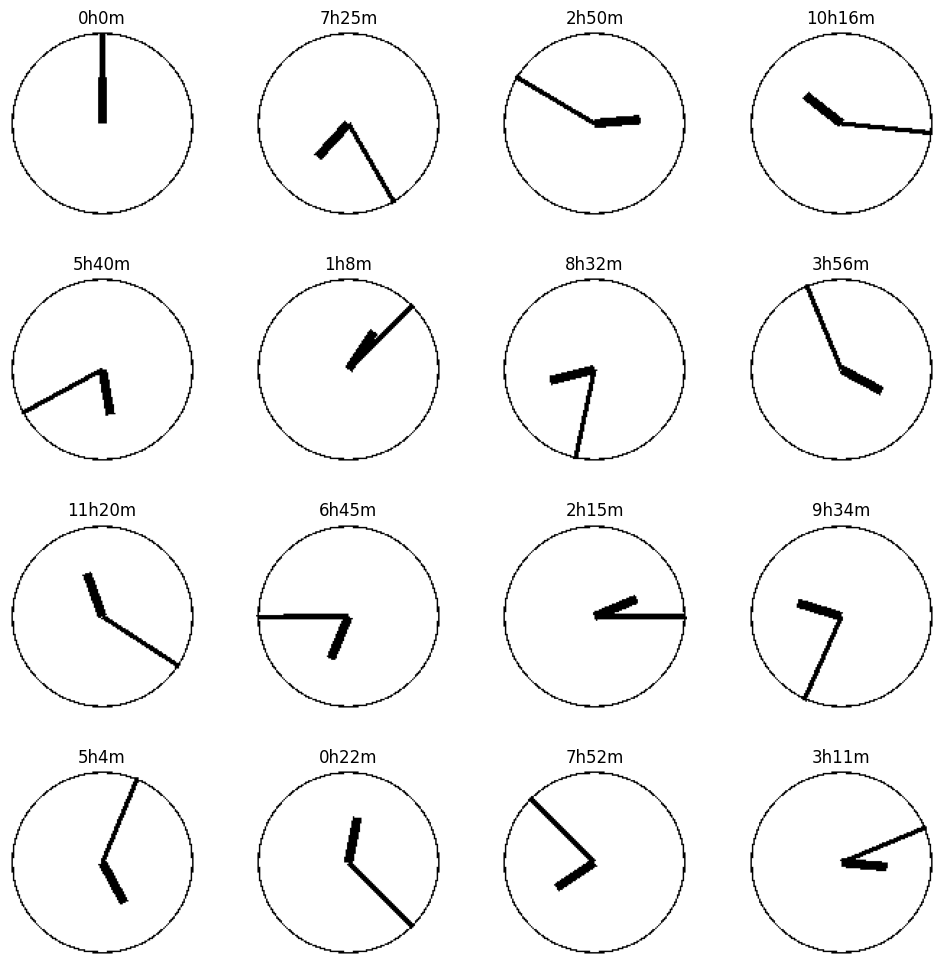

In [30]:
import torch
from torch.utils.data import DataLoader
from datasets.clock import ClockDataset
import matplotlib.pyplot as plt
import numpy as np


IMG_SIZE = 128
BATCH_SIZE = 64
data_size = 16

dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, minute_hand_len=1, augment=False, supervised=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# visualize 16 images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.tight_layout()
batch, labels2d, _ = next(iter(dataloader))
for i in range(16):
    img = batch[i].unsqueeze(0)
    label = labels2d[i].numpy()
    hour = label[0] * 12
    minute = label[1] * 60
    axs[i // 4, i % 4].imshow(img[0].squeeze(), cmap='gray')
    axs[i // 4, i % 4].set_title(f"{hour:.0f}h{minute:.0f}m")
    axs[i // 4, i % 4].axis('off')
# hour = label[0] * 12
# minute = label[1] * 60
# axs[i // 4, i % 4].imshow(img[0], cmap='gray')
# axs[i // 4, i % 4].set_title(f"{hour:.0f}h{minute:.0f}m")
# axs[i // 4, i % 4].axis('off')

plt.show()

# Models

## Visualize AE latents

In [1]:
import os
from datasets.clock import ClockDataset
import torch
from torch.utils.data import DataLoader
from config import MODELS_DIR

OUT_DIM = 2

def load_model_and_dataset(
    img_size=128,
    batch_size=64,
    data_size=2048,
    out_dim=2,
    postfix='',
    tag='model',
):
    """
    Load the model and dataset for inference.
    """
    # Load dataset
    dataset = ClockDataset(len=data_size, img_size=img_size, minute_hand_len=1, augment=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Load trained model
    model_file = f"ae-{out_dim}-i{img_size}{postfix}.pt"
    model_path = os.path.join(MODELS_DIR, tag, model_file)

    model = torch.jit.load(model_path).to(device)
    
    return model, dataloader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


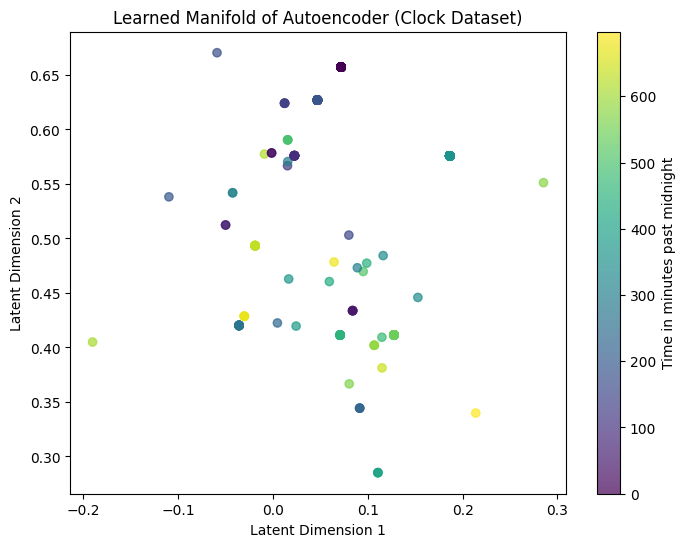

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


model, dataloader = load_model_and_dataset(
    img_size=64,
    batch_size=64,
    out_dim=OUT_DIM,
    tag='small-autoencoder',
    postfix='-d14.trace'
)

# Extract latent representations
latents = []
labels = []

with torch.no_grad():
    for images, labels_2d, labels_1d in dataloader:
        images = images.to(device)
        _, out = model(images)
        latents.append(out.cpu().numpy())
        labels.append(labels_1d.numpy())

latents = np.concatenate(latents, axis=0)

labels = np.concatenate(labels, axis=0) * (12 * 60)  # Denormalize to minutes past midnight

if (OUT_DIM <= 2):
  # Plot latent space
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(latents[:, 0], labels if OUT_DIM==1 else latents[:,1], c=labels, cmap="viridis", alpha=0.7)
  plt.colorbar(scatter, label="Time in minutes past midnight")
  plt.xlabel("Latent Dimension 1")
  plt.ylabel("Time in minutes past midnight" if OUT_DIM==1 else "Latent Dimension 2")
  plt.title("Learned Manifold of Autoencoder (Clock Dataset)")
  plt.show()
else:
  # PCA for dimensionality reduction
  pca = PCA(n_components=2)
  latents_2d = pca.fit_transform(latents)

  # Plot PCA-reduced latent space
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
  plt.colorbar(scatter, label="Time in minutes past midnight")
  plt.xlabel("PCA Component 1")
  plt.ylabel("PCA Component 2")
  
  plt.title("Learned Manifold of Autoencoder (Clock Dataset)")
  plt.show()
  


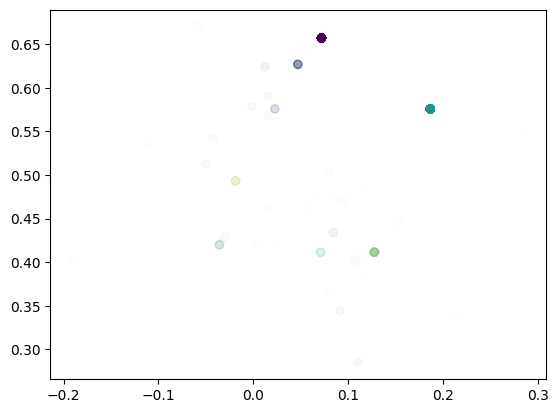

In [29]:

n=1000
plt.scatter(latents[:n, 0], latents[:n, 1], c=labels[:n], cmap="viridis", alpha=0.01)

## Visualize reconstruction

In [31]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(0, len(dataset))
img = dataset[idx][0]

print(img.shape)

out, latent = model.forward(img.to(device))
img = img.squeeze(0).detach().cpu().numpy()
out = out.squeeze(0).detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img[0], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out[0], cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()



torch.Size([1, 64, 64])


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/models.py", line 13, in forward
    x: Tensor) -> Tuple[Tensor, Tensor]:
    encoder = self.encoder
    latent = (encoder).forward(x, )
              ~~~~~~~~~~~~~~~~ <--- HERE
    decoder = self.decoder
    reconstructed = (decoder).forward(latent, )
  File "code/__torch__/torch/nn/modules/container.py", line 54, in forward
    _21 = getattr(self, "21")
    _22 = getattr(self, "22")
    input0 = (_0).forward(input, )
              ~~~~~~~~~~~ <--- HERE
    input1 = (_1).forward(input0, )
    input2 = (_2).forward(input1, )
  File "code/__torch__/torch/nn/modules/conv.py", line 23, in forward
    weight = self.weight
    bias = self.bias
    _0 = (self)._conv_forward(input, weight, bias, )
          ~~~~~~~~~~~~~~~~~~~ <--- HERE
    return _0
  def _conv_forward(self: __torch__.torch.nn.modules.conv.Conv2d,
  File "code/__torch__/torch/nn/modules/conv.py", line 29, in _conv_forward
    weight: Tensor,
    bias: Optional[Tensor]) -> Tensor:
    _1 = torch.conv2d(input, weight, bias, [2, 2], [1, 1], [1, 1])
         ~~~~~~~~~~~~ <--- HERE
    return _1
class ConvTranspose2d(Module):

Traceback of TorchScript, original code (most recent call last):
  File "/mnt/ffs24/home/moham147/experiments/manifold-learning/models.py", line 241, in forward
    def forward(self, x):
        latent = self.encoder(x)
                 ~~~~~~~~~~~~ <--- HERE
        reconstructed = self.decoder(latent)
        return reconstructed, latent
  File "/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/container.py", line 250, in forward
    def forward(self, input):
        for module in self:
            input = module(input)
                    ~~~~~~ <--- HERE
        return input
  File "/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/conv.py", line 554, in forward
    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)
               ~~~~~~~~~~~~~~~~~~ <--- HERE
  File "/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/conv.py", line 549, in _conv_forward
                self.groups,
            )
        return F.conv2d(
               ~~~~~~~~ <--- HERE
            input, weight, bias, self.stride, self.padding, self.dilation, self.groups
        )
RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 64]


# Visualize Regressor latents

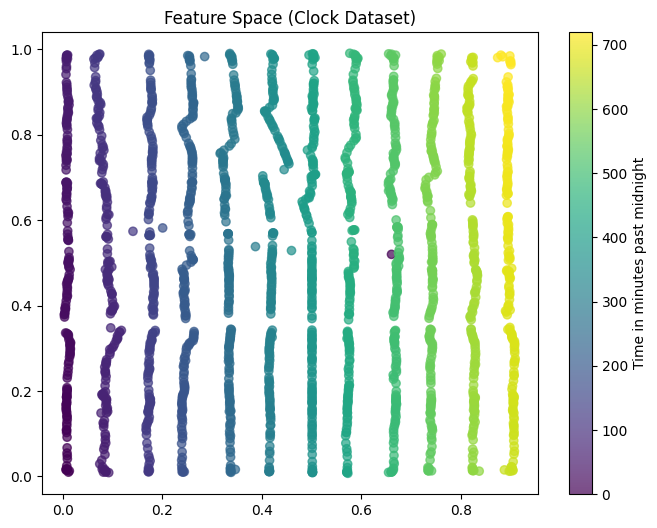

In [11]:
import os
from datasets.clock import ClockDataset
import torch
from torch.utils.data import DataLoader
from config import MODELS_DIR
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
BATCH_SIZE = 64
IMG_SIZE = 128
data_size = 2048
dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, augment=False)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)

# Load trained model
OUT_DIM = 2

# model_file = f"ae-{out_dim}-d22-p22-houronly.pt"
model_file = f"reg-{OUT_DIM}-d23-p18-i{IMG_SIZE}.pt"

model_path = os.path.join(MODELS_DIR, model_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()


# Extract latent representations
feats = []
feats_head1 = []
feats_head2 = []
labels1d = []
labels2d = []

with torch.no_grad():
  for images, label_2d, label_1d in dataloader:
    images = images.to(device)
    out = model.forward(images)

    feats.append(out.cpu().numpy())
    labels1d.append(label_1d.numpy())
    labels2d.append(label_2d.numpy())

    out1 = model.conv1(images)
    out_head1 = model.head1(out1)
    out_head2 = model.head2(out1)
    feats_head1.append(out_head1.cpu().numpy())
    feats_head2.append(out_head2.cpu().numpy())


feats = np.concatenate(feats, axis=0)
labels1d = np.concatenate(labels1d, axis=0) * (12 * 60)  # Denormalize to minutes past midnight
labels2d = np.concatenate(labels2d, axis=0)  # Denormalize to minutes past midnight

feats_head1 = np.concatenate(feats_head1, axis=0)
feats_head2 = np.concatenate(feats_head2, axis=0)

# Plot latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feats[:, 0], feats[:, 1], c=labels1d, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Time in minutes past midnight")
plt.title("Feature Space (Clock Dataset)")
plt.show()



In [12]:
# Check examples of predicted vs true label

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets.clock import ClockDataset
from torch.utils.data import DataLoader
from config import MODELS_DIR
import os

# Load dataset
BATCH_SIZE = 64



(2048, 2)

## Attempt to predict labels using heads

Head differentiation: head1 predicts label0, head2 predicts label1.

In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# try to predict first or second label using head1 and head2
# Predict first label using head1
def fit_mlp(feat_idx, x):
  y = labels[:, feat_idx]
  x_train, x_test, y_train, y_test = train_test_split(feats_head1, y, test_size=0.2, random_state=42)
  model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=1000)
  model.fit(x_train, y_train)

  y_pred = model.predict(x_test)
  mse = mean_squared_error(y_test, y_pred)

  print(f"Mean Squared Error (Head 1): {mse}")

fit_mlp(0, feats_head1)
fit_mlp(1, feats_head1)
fit_mlp(0, feats_head2)
fit_mlp(1, feats_head2)


Mean Squared Error (Head 1): 988.7281494140625


/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error (Head 1): 3669.49951171875
Mean Squared Error (Head 1): 879.5015869140625
Mean Squared Error (Head 1): 3783.881591796875


/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


# UMAP

(2048,)

In [ ]:
# Do umap on the 

import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from datasets.clock import IMG_SIZE, ClockDataset

BATCH_SIZE = 16
dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, augment=False)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Sample the first 5000 data points
subset_size = 5000
subset_indices = np.random.choice(len(dataset), size=subset_size, replace=False)